# HW6: Machine learning

**Due Wednesday April 6, 8pm**

(AY250 2022)

## Galaxy Classification with CNNs

Galaxies appear with different shapes and colors depending on a number of factors, including age, distance, and history of mergers with other galaxies. A crowd-sourced group was [asked to visually classify a set of galaxies from a telescope survey](https://data.galaxyzoo.org/gz_trees/gz_trees.html), resulting in a labelled dataset of 21,785 galaxies across 10 different labels.

You can download it locally:
```bash
curl -o galaxies10.h5 http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
```
Or access it on the shared drive on `astro.datahub.berkeley.edu` at `shared/HW_6/galaxies10.h5`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!curl -o galaxies10.h5 http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  200M  100  200M    0     0  66.7M      0  0:00:03  0:00:03 --:--:-- 66.7M


First, load the data:

In [3]:
import h5py
import numpy as np
from tensorflow.keras import utils

# To get the images and labels from file
with h5py.File('galaxies10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# Convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# Convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32) / 255

print(f"labels shape: {labels.shape}")
print(f"images shape: {images.shape}")

labels shape: (21785, 10)
images shape: (21785, 69, 69, 3)


### Visualize and inspect

In a single, multi-panel figure visualize one randomly chosen galaxy from each of the 10 classes. Be sure to set the random seed so that your figure will be reproducible. 

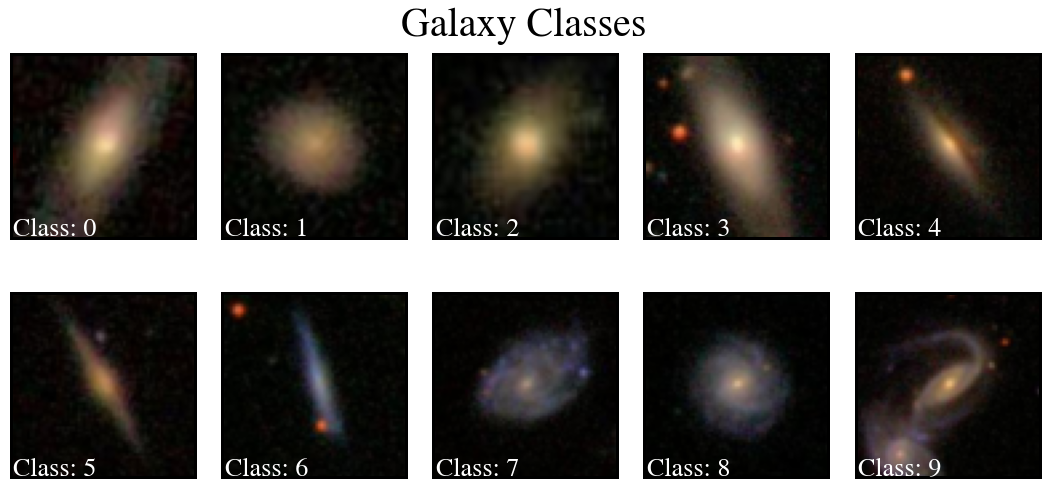

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rcParams['axes.linewidth'] = 3 #set the value globally
plt.rcParams['mathtext.fontset'],plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 22})

np.random.seed(101)

f, axes = plt.subplots(2,5, figsize=(15,7.5))
f.suptitle("Galaxy Classes", fontsize=40)
k = 0
for i in range(2):
    for j in range(5):
        ax = axes[i,j]
        indeces = np.where(labels[:,k] == 1.0)[0]
        index = np.random.randint(low=0, high=len(indeces))
        galaxy_index = indeces[index]
        
        ax.imshow(images[galaxy_index, :,:,:], 
                 origin="lower")
        ax.text(0.5,0.5,f"Class: {k}", color="white", fontsize=26)
        ax.set_xticks([])
        ax.set_yticks([])
        k+=1
        
        
f.tight_layout()

Show a histogram of the distribution of galaxies across classes. Comment on any differences you notice with this dataset and the MNIST.

In [5]:
import tensorflow as tf
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


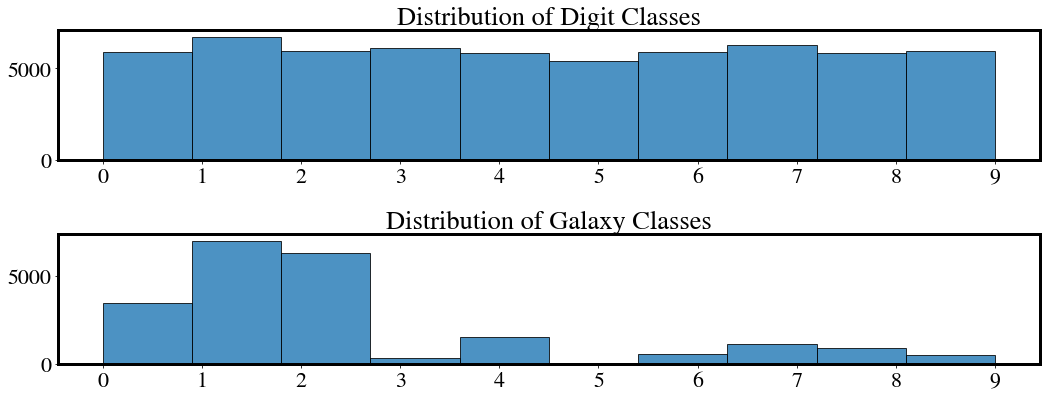

In [12]:
classes = []
for k in range(0,10):
    num_class = len(np.where(labels[:,k] == 1.0)[0])
    
    classes.extend([k]*num_class)

f,axes = plt.subplots(2,1, figsize=(15,6))

axes[0].set_title("Distribution of Digit Classes")
axes[0].hist(train_labels, bins=10, alpha=0.8, edgecolor = "black")
axes[0].set_xticks(range(0,10))

axes[1].set_title("Distribution of Galaxy Classes")
axes[1].hist(classes, bins=10, alpha=0.8, edgecolor = "black")
axes[1].set_xticks(range(0,10))
plt.tight_layout()
plt.show()

**Answer:** It is clear to me that the MNIST data set is approximately a uniform distribution where the distribution of Galaxy classes is not nearly as uniform. We see that classes 0, 1, and 2 are by far the most common classes in this data set. I would like to point out that this galaxy dataset is also more difficult to work with since we have RGB channels for every image, meaning a lot more data to train on.

In [13]:
#Import necessary packages, standard ML preamble
import datetime, os
import numpy as np
import warnings

from IPython.external import mathjax
from sklearn.model_selection import train_test_split

import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Activation, BatchNormalization #switch to 3D CNN
)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
# Print keras version
print("Using tensorflow version:", tensorflow.keras.__version__)

Using tensorflow version: 2.8.0


### Prepare for training

First, split the dataset into a train, validation, and test set with a fixed random seed. Then, construct a simple (~few layers) CNN that will accommodate the 69x69x3 images and return a classification. Hint: you will need to modify the networks we built in class to handle the 3d inputs (check out `Conv3D` https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D).

**NOTE FOR GRADER:** I did look into using the 3D convolutional neural networks but I felt that it was uneccessary for our problem. The Conv2D takes in RGB data as well as single color filter data. It is true that you can force a Conv3D to accomplish the same thing but there is far more support and examples online of people using Conv2D for RGB data. It is for this reason I chose to modify the Conv2D example from class to work for RGB data.

In [14]:
#shuffle the data
np.random.seed(7)
shuffled_indeces=np.random.permutation(range(len(labels[:,0])))
X = images[shuffled_indeces,:,:,:]
Y = labels[shuffled_indeces,:]
# pick training and test data sets 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.8) #it defaults to already shuffling the data?

In [15]:
input_shape = X_train[0].shape
nb_classes = 10
batch_size = 128
input_shape

(69, 69, 3)

In [10]:

# add with tf.device('/gpu:0'): if on GPU

with tf.device('/gpu:0'):
  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3,3), input_shape=input_shape))
  model.add(Activation('relu'))

  model.add(Flatten())

  model.add(Dense(128, activation='relu'))

  model.add(Dense(32, activation='relu'))


  model.add(Dense(nb_classes))
  model.add(Activation('softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 67, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 67, 67, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 67, 67, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 31, 31, 64)        0

### Train

Using early stopping and learning rate decay, train the network you built. Use the validation dataset at the end of each epoch for the early stopping. You might decide to do this part on colab for GPU access.

In [12]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [13]:
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'ay250_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

csv_logger = tf.keras.callbacks.CSVLogger(f'training_{run_time_string}.log')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                             patience=3, \
                                             verbose=1, mode='auto')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

model.fit(x=X_train.reshape(-1,69,69,3), 
          y=Y_train, 
          epochs=20,
          batch_size=batch_size,
          validation_data=(X_test.reshape(-1,69,69,3), Y_test), 
          callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... ay250_nn_2022-04-06T00:09.h5
Epoch 1/20
137/137 [==============================] - ETA: 0s - loss: 1.6272 - accuracy: 0.4007
Epoch 1: val_accuracy improved from -inf to 0.33716, saving model to ay250_nn_2022-04-06T00:09.h5
137/137 [==============================] - 17s 42ms/step - loss: 1.6272 - accuracy: 0.4007 - val_loss: 1.8379 - val_accuracy: 0.3372 - lr: 0.0010
Epoch 2/20
136/137 [============================>.] - ETA: 0s - loss: 1.0711 - accuracy: 0.5989
Epoch 2: val_accuracy improved from 0.33716 to 0.54808, saving model to ay250_nn_2022-04-06T00:09.h5
137/137 [==============================] - 5s 38ms/step - loss: 1.0712 - accuracy: 0.5990 - val_loss: 1.3794 - val_accuracy: 0.5481 - lr: 0.0010
Epoch 3/20
136/137 [============================>.] - ETA: 0s - loss: 0.8343 - accuracy: 0.6956
Epoch 3: val_accuracy improved from 0.54808 to 0.67087, saving model to ay250_nn_2022-04-06T00:09.h5
137/137 [==============================] - 5s 37ms/step - loss: 0.8345 - accura

### Evaluation

Use your trained model and apply it to the test set. How well did you do (total accuracy)? Plot a confusion matrix and comment where the network was most confused.

In [14]:
import sklearn.metrics as metrics

In [15]:
prediction_labels = model.predict(X_test)
prediction_labels = np.rint(prediction_labels)

In [16]:
confusion_matrix = metrics.confusion_matrix(y_true=Y_test.argmax(axis=1), y_pred=prediction_labels.argmax(axis=1), labels=[0,1,2,3,4,5,6,7,8,9])  

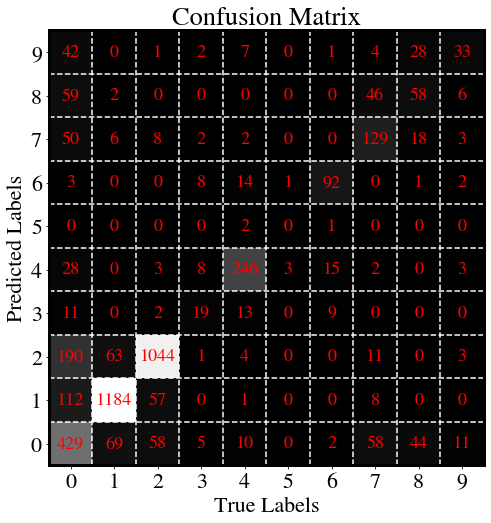

In [17]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

f, ax = plt.subplots(1,1,figsize=(10,8))
ax.set_title("Confusion Matrix")
ax.imshow(confusion_matrix, origin="lower", cmap="Greys_r")
for i in range(10):
    ax.vlines(x=i-0.5,ymin=-0.5,ymax=9.5, color="white", linestyle="--")
    ax.hlines(y=i-0.5,xmin=-0.5,xmax=9.5, color="white", linestyle="--")
    # norm = np.sum(confusion_matrix[i, :])
    norm=100
    for j in range(10):
        label_str = "{0:0.0f}".format(confusion_matrix[i, j]/norm * 100)
        text = ax.text(j, i, label_str,
                       ha="center", va="center", color="red", fontsize=18)


ax.set_ylabel("Predicted Labels")
ax.set_xlabel("True Labels")
ax.set_xticks(range(10))
ax.set_yticks(range(10))
plt.show()

In [18]:
# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
mse = mean_squared_error(Y_test, prediction_labels)
accuracy = accuracy_score(Y_test, prediction_labels)
print("Mean Squared Error",mse)
print("Accuracy",accuracy)

Mean Squared Error 0.050103284
Accuracy 0.7266467753041084


In [23]:
X_train.shape

(17428, 69, 69, 3)

### Improve - data augmentation

Now that you have a baseline accuracy, you can work to try to improve the results. Without changing your network architecture, implement a data augmentation strategy, retrain, and then reevaluate. How much improvement did you see?

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# creating the data aumentation genreators for both the training images and the training label masks
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=15.,
                     rescale=1.0,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode = 'nearest')

image_datagen = ImageDataGenerator(**data_gen_args)

seed = 42
batch_size = 128


image_generator = image_datagen.flow(
    X_train,  Y_train,
    shuffle = True,
    batch_size=batch_size,
    seed=seed)

"""tuple where the 0th element is the X_new_train and 1st element is Y_new_train 
each with batch_size number of new images and labels."""
new_data = image_generator.next() 


In [10]:
# Combine new data with old data

X_train_new = np.append(X_train, new_data[0], axis=0)
Y_train_new = np.append(Y_train, new_data[1], axis=0)

In [19]:
input_shape = X_train_new[0].shape
nb_classes = 10
batch_size = 128
input_shape

with tf.device('/gpu:0'):
  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3,3), input_shape=input_shape))
  model.add(Activation('relu'))

  model.add(Flatten())

  model.add(Dense(128, activation='relu'))

  model.add(Dense(32, activation='relu'))


  model.add(Dense(nb_classes))
  model.add(Activation('softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 67, 67, 32)        896       
                                                                 
 batch_normalization_1 (Batc  (None, 67, 67, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 67, 67, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 33, 33, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 activation_5 (Activation)   (None, 31, 31, 64)       

In [20]:
batch_size

128

In [23]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'ay250_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

csv_logger = tf.keras.callbacks.CSVLogger(f'training_{run_time_string}.log')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                            patience=3, \
                                            verbose=1, mode='auto')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

model.fit(image_generator,
          epochs=20,
          batch_size=batch_size,
          validation_data=(X_test.reshape(-1,69,69,3), Y_test), 
          callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... ay250_nn_2022-04-06T00:44.h5
Epoch 1/20
137/137 [==============================] - ETA: 0s - loss: 1.5045 - accuracy: 0.4360
Epoch 1: val_accuracy improved from -inf to 0.53776, saving model to ay250_nn_2022-04-06T00:44.h5
137/137 [==============================] - 27s 188ms/step - loss: 1.5045 - accuracy: 0.4360 - val_loss: 1.9042 - val_accuracy: 0.5378 - lr: 0.0010
Epoch 2/20
137/137 [==============================] - ETA: 0s - loss: 1.0232 - accuracy: 0.6074
Epoch 2: val_accuracy improved from 0.53776 to 0.65940, saving model to ay250_nn_2022-04-06T00:44.h5
137/137 [==============================] - 25s 186ms/step - loss: 1.0232 - accuracy: 0.6074 - val_loss: 1.4053 - val_accuracy: 0.6594 - lr: 0.0010
Epoch 3/20
137/137 [==============================] - ETA: 0s - loss: 0.8864 - accuracy: 0.6628
Epoch 3: val_accuracy improved from 0.65940 to 0.66812, saving model to ay250_nn_2022-04-06T00:44.h5
137/137 [==============================] - 26s 188ms/step - loss: 0.8864 - a

In [24]:
# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

prediction_labels = model.predict(X_test)
prediction_labels = np.rint(prediction_labels)
mse = mean_squared_error(Y_test, prediction_labels)
accuracy = accuracy_score(Y_test, prediction_labels)
print("Mean Squared Error",mse)
print("Accuracy",accuracy)

Mean Squared Error 0.037158597
Accuracy 0.7870094101445949


**Answer:** If we add samples to our training data through data augmentation we see $\sim 6\%$ increase in testing accuracy. This was achieved using a `batch_size` of 128. 

### Improve - network

Change/embellish your original network to try to improve the results (try adding layers, changing the initialization of the kernel weights, changing the activation, adding dropout). You can use an automl trainer if you'd like or try different approaches by hand. Retrain and then reevaluate. Explain what you did but only show us the best model and its evaluation.

In [16]:
def build_model(hp):
  with tf.device('/gpu:0'):
    model = Sequential()
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    model.add(Conv2D(
              filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16), 
              kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
              input_shape=input_shape,
              activation=hp.Choice('conv_1_activation', values=['relu', 'sigmoid'])))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.1))
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    model.add(Conv2D(
              filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
              kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
              input_shape=input_shape,
              activation=hp.Choice('conv_2_activation', values=['relu', 'sigmoid'])))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.1))
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    model.add(Conv2D(
              filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
              kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
              input_shape=input_shape,
              activation=hp.Choice('conv_3_activation', values=['relu', 'sigmoid'])))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.1))
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    model.add(Conv2D(
              filters=hp.Int('conv_4_filter', min_value=32, max_value=128, step=16),
              kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
              input_shape=input_shape,
              activation=hp.Choice('conv_4_activation', values=['relu', 'sigmoid'])))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.1))
    model.add(Flatten())
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    model.add(Dense(
              units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
              activation='relu'))
    model.add(Dropout(rate=0.2))
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    model.add(Dense(32, activation='relu'))
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    return model

In [ ]:
pip install keras-tuner --upgrade

In [29]:
#importing random search
from keras_tuner import RandomSearch, Hyperband, BayesianOptimization

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'ay250_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

csv_logger = tf.keras.callbacks.CSVLogger(f'training_{run_time_string}.log')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                             patience=3, \
                                             verbose=1, mode='auto')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

#creating randomsearch object
tuner = BayesianOptimization(build_model,
                    objective='val_accuracy',
                    overwrite=True,
                    max_trials = 10)
# search best parameter
tuner.search(X_train,Y_train,
             epochs=20,
             validation_data=(X_test.reshape(-1,69,69,3), Y_test),
             callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

tuner.search_space_summary()

Trial 10 Complete [00h 03m 44s]
val_accuracy: 0.8140922784805298

Best val_accuracy So Far: 0.8193711042404175
Total elapsed time: 00h 38m 09s
Search space summary
Default search space size: 13
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_1_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_2_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid'], 'ordered': False}
conv_3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_3_kernel (Choice)
{'default'

In [ ]:
tuner.results_summary()

Best Hyperparameters:
- conv_1_filter: 112
- conv_1_kernel: 3
- conv_1_activation: relu
- conv_2_filter: 128
- conv_2_kernel: 5
- conv_2_activation: sigmoid
- conv_3_filter: 128
- conv_3_kernel: 3
- conv_3_activation: relu
- conv_4_filter: 64
- conv_4_kernel: 3
- conv_4_activation: relu
- dense_1_units: 32
- Score: 0.8193711042404175

In [37]:
best_hps = tuner.get_best_hyperparameters()[0]

In [35]:
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 67, 112)       3136      
                                                                 
 batch_normalization (BatchN  (None, 67, 67, 112)      448       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 112)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 33, 33, 112)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       358528    
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 128)      5

In [41]:
#save best model
best_model_of_all = build_model(best_hps)
best_model_of_all.save('best_model_of_all.h5')

In [22]:
#load in best model
from tensorflow import keras
model = keras.models.load_model('best_model_of_all.h5')


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# creating the data aumentation genreators for both the training images and the training label masks
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=15.,
                     rescale=1.0,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode = 'nearest')

image_datagen = ImageDataGenerator(**data_gen_args)

seed = 42
batch_size = 128


image_generator = image_datagen.flow(
    X_train,  Y_train,
    shuffle = True,
    batch_size=batch_size,
    seed=seed)

"""tuple where the 0th element is the X_new_train and 1st element is Y_new_train 
each with batch_size number of new images and labels."""
new_data = image_generator.next() 

In [24]:
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'ay250_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

csv_logger = tf.keras.callbacks.CSVLogger(f'training_{run_time_string}.log')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                            patience=3, \
                                            verbose=1, mode='auto')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

model.fit(image_generator,
          epochs=20,
          batch_size=batch_size,
          validation_data=(X_test.reshape(-1,69,69,3), Y_test), 
          callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... ay250_nn_2022-04-06T06:37.h5
Epoch 1/20
137/137 [==============================] - ETA: 0s - loss: 1.4035 - accuracy: 0.4711
Epoch 1: val_accuracy improved from -inf to 0.30847, saving model to ay250_nn_2022-04-06T06:37.h5
137/137 [==============================] - 46s 257ms/step - loss: 1.4035 - accuracy: 0.4711 - val_loss: 2.1718 - val_accuracy: 0.3085 - lr: 0.0010
Epoch 2/20
137/137 [==============================] - ETA: 0s - loss: 0.9996 - accuracy: 0.6320
Epoch 2: val_accuracy did not improve from 0.30847
137/137 [==============================] - 36s 262ms/step - loss: 0.9996 - accuracy: 0.6320 - val_loss: 4.2668 - val_accuracy: 0.3020 - lr: 0.0010
Epoch 3/20
137/137 [==============================] - ETA: 0s - loss: 0.8707 - accuracy: 0.6824
Epoch 3: val_accuracy improved from 0.30847 to 0.43631, saving model to ay250_nn_2022-04-06T06:37.h5
137/137 [==============================] - 36s 265ms/step - loss: 0.8707 - accuracy: 0.6824 - val_loss: 2.9053 - val_accuracy:

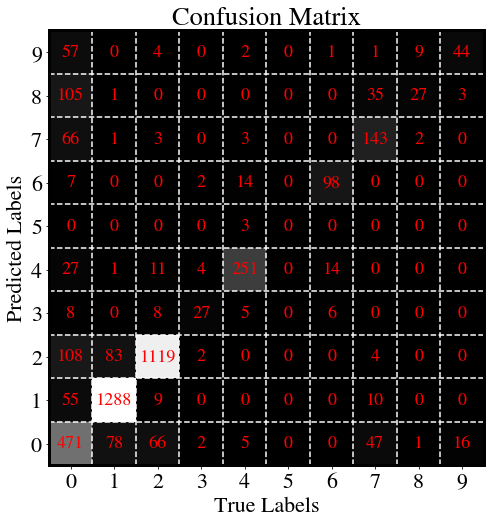

Mean Squared Error 0.037663527
Accuracy 0.7672710580674776


In [26]:
import sklearn.metrics as metrics
prediction_labels = model.predict(X_test)
prediction_labels = np.rint(prediction_labels)
confusion_matrix = metrics.confusion_matrix(y_true=Y_test.argmax(axis=1), 
                                            y_pred=prediction_labels.argmax(axis=1),
                                            labels=[0,1,2,3,4,5,6,7,8,9])  

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

f, ax = plt.subplots(1,1,figsize=(10,8))
ax.set_title("Confusion Matrix")
ax.imshow(confusion_matrix, origin="lower", cmap="Greys_r")
for i in range(10):
    ax.vlines(x=i-0.5,ymin=-0.5,ymax=9.5, color="white", linestyle="--")
    ax.hlines(y=i-0.5,xmin=-0.5,xmax=9.5, color="white", linestyle="--")
    # norm = np.sum(confusion_matrix[i, :])
    norm=100
    for j in range(10):
        label_str = "{0:0.0f}".format(confusion_matrix[i, j]/norm * 100)
        text = ax.text(j, i, label_str,
                       ha="center", va="center", color="red", fontsize=18)


ax.set_ylabel("Predicted Labels")
ax.set_xlabel("True Labels")
ax.set_xticks(range(10))
ax.set_yticks(range(10))
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
mse = mean_squared_error(Y_test, prediction_labels)
accuracy = accuracy_score(Y_test, prediction_labels)
print("Mean Squared Error",mse)
print("Accuracy",accuracy)

**Answer:** For this section, in order to keep the model within a reasonable size I limited the number of convolutional layers to 4. To get to my best model I used the `BayesianOptimization` function in Keras to search a parameter space for building the Neural Network. I allowed each Convolutional layer to vary filter size, kernel size, and activation functions. I also allowed one of the dense layers to change filter size as well. I chose BayesianOptimization instead of the standard Grid Search because I wanted reduce the amount of time wasted training for this homework assignment. I found the best hyperparameters to be:

- conv_1_filter: 112
- conv_1_kernel: 3
- conv_1_activation: relu
- conv_2_filter: 128
- conv_2_kernel: 5
- conv_2_activation: sigmoid
- conv_3_filter: 128
- conv_3_kernel: 3
- conv_3_activation: relu
- conv_4_filter: 64
- conv_4_kernel: 3
- conv_4_activation: relu
- dense_1_units: 32
- Score: 0.8193711042404175

This set of hyperparameters got a validation accuracy of nearly $\sim 82\%$ but when applied in practice with data augmentation we only got a testing accuracy of $\sim 77 \%$ which is nearly $5\%$ better than our original model. If I had more time I would allow this parameter search to span many more possibilities with more layers but unfortunately the deadline does not allow me such time and google colab kicked me off the GPU after spending the whole day working on it. Without the GPU this will be drastically slower and difficult to train any further.

## Autoencoders

A form of non-parametric representation learning with neutral nets, where the architecture of the network is used to reduce the dimensionality of the data. First, go through (and execute) the following codeblocks and make sure you understand what they are doing to build and use an autoencoder.

As the name suggests, autoencoders uses the data itself to learn the best way to represent it in a compact way--it's a form of semantic compression. This is a family of self- (or un-) supervised modeling.

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png">
Source: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

In practice, we take an input X (which may be a 1-d vector, 2-d image, ...) and try to squeeze it down to a smaller number of values in the "bottleneck" layer and then uncompress back to it's original shape and form. The loss function that we construct will be the way in which the network learns on each backprop through the data.

Let's look at a autoencoder which uses convnets to restruct the fashion dataset.

In [27]:
import datetime, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow 
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, \
                                    Activation, BatchNormalization, UpSampling2D
from tensorflow.keras import backend as K
import tensorflow as tf

# Print keras version
print(tensorflow.keras.__version__)

from tensorflow.keras.utils import to_categorical

fashion_mnist = tf.keras.datasets.fashion_mnist

nb_classes = 10
batch_size = 128
bottleneck_size = 64

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # scale the images to 0-1

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

input_shape = x_train[0].shape  + (1,)
input_shape
input_img = Input(shape = (28, 28, 1))

2.8.0
4431872/4422102 [==============================] - 0s 0us/step


Make a simple autoencoder

In [28]:
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Flatten()(x)
bottleneck = Dense(bottleneck_size, name="bottleneck")(x)

x = Dense(128)(bottleneck)
x = Reshape((4, 4, 8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

with tf.device('/gpu:0'):
  autoencoder = Model(input_img, decoded)


  logdir = os.path.join(
      "nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

  model_path = f'nn_results/ay250_autoencoder_nn_{run_time_string}.h5'
  print(f"Training ... {model_path}")


  model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  mode='min',
                                                  verbose=1)

  tensorboard_callback = \
      tensorflow.keras.callbacks.TensorBoard(logdir,
                                            histogram_freq=0,
                                            write_graph=True,
                                            write_grads=False,
                                            write_images=False,
                                            embeddings_freq=0,
                                            embeddings_layer_names=None,
                                            embeddings_metadata=None, embeddings_data=None)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_train = autoencoder.fit(x_train, x_train,
                                    batch_size=batch_size, epochs=10,
                                    verbose=1, shuffle=False,
                                    validation_data=(x_test, x_test),
                                    callbacks=[tensorboard_callback, model_check])

Training ... nn_results/ay250_autoencoder_nn_2022-04-06T07:04.h5
Epoch 1/10
469/469 [==============================] - ETA: 0s - loss: 0.0355
Epoch 1: val_loss improved from inf to 0.02681, saving model to nn_results/ay250_autoencoder_nn_2022-04-06T07:04.h5
469/469 [==============================] - 8s 14ms/step - loss: 0.0355 - val_loss: 0.0268
Epoch 2/10
465/469 [============================>.] - ETA: 0s - loss: 0.0219
Epoch 2: val_loss improved from 0.02681 to 0.01994, saving model to nn_results/ay250_autoencoder_nn_2022-04-06T07:04.h5
469/469 [==============================] - 6s 12ms/step - loss: 0.0219 - val_loss: 0.0199
Epoch 3/10
468/469 [============================>.] - ETA: 0s - loss: 0.0194
Epoch 3: val_loss improved from 0.01994 to 0.01824, saving model to nn_results/ay250_autoencoder_nn_2022-04-06T07:04.h5
469/469 [==============================] - 5s 12ms/step - loss: 0.0194 - val_loss: 0.0182
Epoch 4/10
465/469 [============================>.] - ETA: 0s - loss: 0.0181
E

In [29]:
from tensorflow.keras.models import load_model
latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
latest_model_file = latest_model_file[0]
print(f"Using {latest_model_file}")
autoencoder = load_model(latest_model_file)

Using nn_results/ay250_autoencoder_nn_2022-04-06T07:04.h5


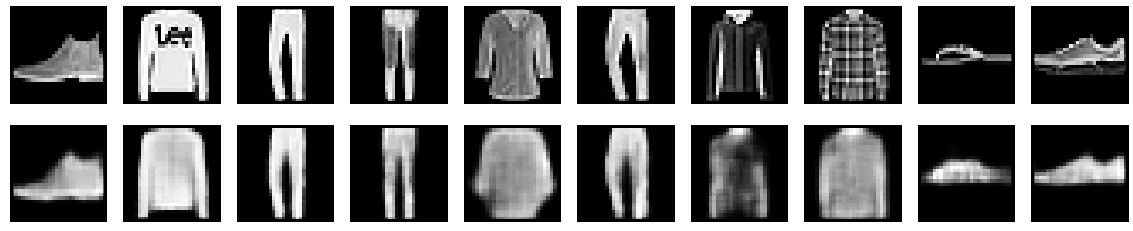

In [30]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Classify using Random Forest

Using the autoencoder model above, create a random forest model to predict the classes of the images using the 64-parameter bottleneck layer. What accuracy do you get? How does it compare with the accuracy we got on the `convnet` model before?

In [42]:
# bottleneck model
bottleneck_output = autoencoder.get_layer('bottleneck').output
model_bottleneck = Model(inputs = autoencoder.input, outputs = bottleneck_output)

bottleneck_train_data = model_bottleneck.predict(x_train)
bottleneck_test_data = model_bottleneck.predict(x_test)

In [45]:
from sklearn.ensemble import RandomForestClassifier

# instantiate classifier object
classifier = RandomForestClassifier(n_estimators=100)

# fit the classification model on training set
classifier.fit(bottleneck_train_data, Y_train)

# make predictions for testing set
final_bottleneck_predictions = classifier.predict(bottleneck_test_data) 


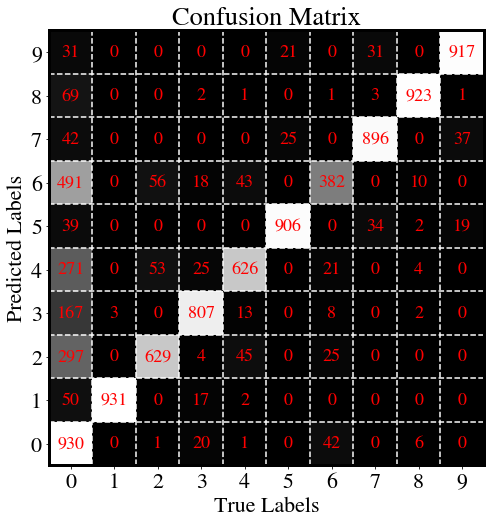

Mean Squared Error 0.02981
Accuracy 0.7738


In [55]:
import sklearn.metrics as metrics

mpl.rcParams['axes.linewidth'] = 3 #set the value globally
plt.rcParams['mathtext.fontset'],plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 22})

prediction_labels = np.rint(final_bottleneck_predictions)
confusion_matrix = metrics.confusion_matrix(y_true=Y_test.argmax(axis=1), 
                                            y_pred=prediction_labels.argmax(axis=1),
                                            labels=[0,1,2,3,4,5,6,7,8,9])  


f, ax = plt.subplots(1,1,figsize=(10,8))
ax.set_title("Confusion Matrix")
ax.imshow(confusion_matrix, origin="lower", cmap="Greys_r")
for i in range(10):
    ax.vlines(x=i-0.5,ymin=-0.5,ymax=9.5, color="white", linestyle="--")
    ax.hlines(y=i-0.5,xmin=-0.5,xmax=9.5, color="white", linestyle="--")
    # norm = np.sum(confusion_matrix[i, :])
    norm=100
    for j in range(10):
        label_str = "{0:0.0f}".format(confusion_matrix[i, j]/norm * 100)
        text = ax.text(j, i, label_str,
                       ha="center", va="center", color="red", fontsize=18)


ax.set_ylabel("Predicted Labels")
ax.set_xlabel("True Labels")
ax.set_xticks(range(10))
ax.set_yticks(range(10))
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
mse = mean_squared_error(Y_test, prediction_labels)
accuracy = accuracy_score(Y_test, prediction_labels)
print("Mean Squared Error",mse)
print("Accuracy",accuracy)

In [57]:
input_shape = x_train[0].shape
nb_classes = 10
batch_size = 128
print(input_shape)

with tf.device('/gpu:0'):
  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3,3), input_shape=input_shape))
  model.add(Activation('relu'))

  model.add(Flatten())

  model.add(Dense(128, activation='relu'))

  model.add(Dense(32, activation='relu'))


  model.add(Dense(nb_classes))
  model.add(Activation('softmax'))



(28, 28, 1)


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'ay250_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

csv_logger = tf.keras.callbacks.CSVLogger(f'training_{run_time_string}.log')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                            patience=3, \
                                            verbose=1, mode='auto')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

model.fit(x=x_train,
          y=Y_train,
          epochs=20,
          batch_size=batch_size,
          validation_data=(x_test.reshape(-1,28,28,1), Y_test), 
          callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

In [59]:
NN_predictions = model.predict(x_test)

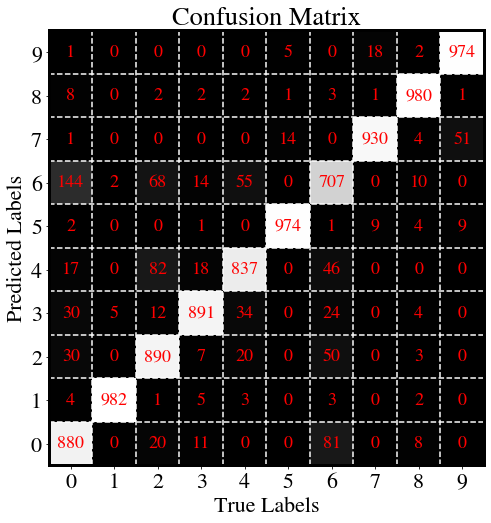

Mean Squared Error 0.01829
Accuracy 0.9031


In [60]:
prediction_labels = np.rint(NN_predictions)
confusion_matrix = metrics.confusion_matrix(y_true=Y_test.argmax(axis=1), 
                                            y_pred=prediction_labels.argmax(axis=1),
                                            labels=[0,1,2,3,4,5,6,7,8,9])  


f, ax = plt.subplots(1,1,figsize=(10,8))
ax.set_title("Confusion Matrix")
ax.imshow(confusion_matrix, origin="lower", cmap="Greys_r")
for i in range(10):
    ax.vlines(x=i-0.5,ymin=-0.5,ymax=9.5, color="white", linestyle="--")
    ax.hlines(y=i-0.5,xmin=-0.5,xmax=9.5, color="white", linestyle="--")
    # norm = np.sum(confusion_matrix[i, :])
    norm=100
    for j in range(10):
        label_str = "{0:0.0f}".format(confusion_matrix[i, j]/norm * 100)
        text = ax.text(j, i, label_str,
                       ha="center", va="center", color="red", fontsize=18)


ax.set_ylabel("Predicted Labels")
ax.set_xlabel("True Labels")
ax.set_xticks(range(10))
ax.set_yticks(range(10))
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
mse = mean_squared_error(Y_test, prediction_labels)
accuracy = accuracy_score(Y_test, prediction_labels)
print("Mean Squared Error",mse)
print("Accuracy",accuracy)

**Answer:** When comparing the random forest classifier to one of the CNNs we made in the first half of the homework for the galaxy images we see that the CNN drastically outperforms the random forest classifier. Furthermore the CNN used is the simplest/least effective model used for the galaxy analysis and it still out performs by $13\%$ in test accuracy. 

### Bottleneck size variation

Experiment with trying a different sized layer (e.g., size 4, 16, 32) and repeat step a) above. Do you see any trends with bottleneck size?

In [68]:
def bottleneck_model_stuff(bottleneck_size):
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  # at this point the representation is (4, 4, 8) i.e. 128-dimensional

  x = Flatten()(x)
  bottleneck = Dense(bottleneck_size, name="bottleneck")(x)

  x = Dense(128)(bottleneck)
  x = Reshape((4, 4, 8))(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation='relu')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


  with tf.device('/gpu:0'):
    autoencoder = Model(input_img, decoded)


    logdir = os.path.join(
        "nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

    model_path = f'nn_results/ay250_autoencoder_nn_{run_time_string}.h5'
    print(f"Training ... {model_path}")


    model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                    monitor='val_loss',
                                                    save_best_only=True,
                                                    mode='min',
                                                    verbose=0)

    tensorboard_callback = \
        tensorflow.keras.callbacks.TensorBoard(logdir,
                                              histogram_freq=0,
                                              write_graph=True,
                                              write_grads=False,
                                              write_images=False,
                                              embeddings_freq=0,
                                              embeddings_layer_names=None,
                                              embeddings_metadata=None, embeddings_data=None)

  autoencoder.compile(optimizer='adam', loss='mean_squared_error')

  autoencoder_train = autoencoder.fit(x_train, x_train,
                                      batch_size=batch_size, epochs=10,
                                      verbose=0, shuffle=False,
                                      validation_data=(x_test, x_test),
                                      callbacks=[tensorboard_callback, model_check])
  
  # bottleneck model
  bottleneck_output = autoencoder.get_layer('bottleneck').output
  model_bottleneck = Model(inputs = autoencoder.input, outputs = bottleneck_output)

  bottleneck_train_data = model_bottleneck.predict(x_train)
  bottleneck_test_data = model_bottleneck.predict(x_test)

  # instantiate classifier object
  classifier = RandomForestClassifier(n_estimators=100)

  # fit the classification model on training set
  classifier.fit(bottleneck_train_data, Y_train)

  # make predictions for testing set
  final_bottleneck_predictions = classifier.predict(bottleneck_test_data) 

  # Metrics
  prediction_labels = np.rint(final_bottleneck_predictions)
  mse = mean_squared_error(Y_test, prediction_labels)
  accuracy = accuracy_score(Y_test, prediction_labels)
  print("Mean Squared Error",mse)
  print("Accuracy",accuracy)
  
  return accuracy, mse


In [66]:
BN_4_acc, BN_4_mse = bottleneck_model_stuff(4)

Training ... nn_results/ay250_autoencoder_nn_2022-04-06T08:00.h5
Epoch 1/10
468/469 [============================>.] - ETA: 0s - loss: 0.0485
Epoch 1: val_loss improved from inf to 0.03550, saving model to nn_results/ay250_autoencoder_nn_2022-04-06T08:00.h5
469/469 [==============================] - 9s 14ms/step - loss: 0.0485 - val_loss: 0.0355
Epoch 2/10
469/469 [==============================] - ETA: 0s - loss: 0.0310
Epoch 2: val_loss improved from 0.03550 to 0.02932, saving model to nn_results/ay250_autoencoder_nn_2022-04-06T08:00.h5
469/469 [==============================] - 6s 13ms/step - loss: 0.0310 - val_loss: 0.0293
Epoch 3/10
465/469 [============================>.] - ETA: 0s - loss: 0.0287
Epoch 3: val_loss improved from 0.02932 to 0.02765, saving model to nn_results/ay250_autoencoder_nn_2022-04-06T08:00.h5
469/469 [==============================] - 6s 13ms/step - loss: 0.0287 - val_loss: 0.0277
Epoch 4/10
468/469 [============================>.] - ETA: 0s - loss: 0.0273
E

In [ ]:
# Repeat for varying bottleneck size.
BN_4_acc, BN_4_mse = bottleneck_model_stuff(4)
BN_16_acc, BN_16_mse = bottleneck_model_stuff(16)
BN_32_acc, BN_32_mse = bottleneck_model_stuff(32)
BN_64_acc, BN_64_mse = bottleneck_model_stuff(64)

Training ... nn_results/ay250_autoencoder_nn_2022-04-06T08:04.h5
Mean Squared Error 0.032870002
Accuracy 0.7562
Training ... nn_results/ay250_autoencoder_nn_2022-04-06T08:06.h5
Mean Squared Error 0.030480001
Accuracy 0.7706
Training ... nn_results/ay250_autoencoder_nn_2022-04-06T08:09.h5


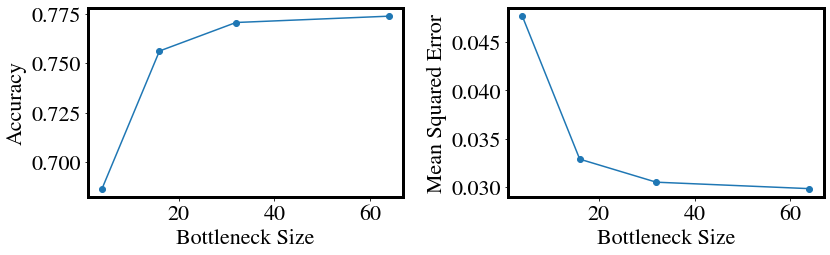

In [10]:
accuracies = [BN_4_acc,BN_16_acc,BN_32_acc,BN_64_acc]
mses = [BN_4_mse,BN_16_mse,BN_32_mse,BN_64_mse]
sizes = [4,16,32,64]

f, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].plot(sizes, accuracies, marker='o')
axes[0].set_xlabel("Bottleneck Size")
axes[0].set_ylabel("Accuracy")

axes[1].plot(sizes, mses, marker='o')
axes[1].set_xlabel("Bottleneck Size")
axes[1].set_ylabel("Mean Squared Error")
plt.tight_layout()
plt.show()

**Answer:** It is clear that we approach an asymptote for accuracy and Mean Squared Error once the bottleneck size is greater than 32. One can achieve nearly the same accuracy as a 64 dimensional bottleneck with only a 32 dimensional bottleneck. There isn't much need to raise the dimensionality any higher, a full CNN is still more accurate than this method.